In [ ]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
def graph_history(history, save_path="training_history"):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure()
    plt.plot(epochs, acc, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc, "b", label="Validation accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"{save_path}_accuracy.png")  
    # Plot Loss
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{save_path}_loss.png")

def fetch_data():
    # Define dataset path and expected file name
    dataset_dir = "./datasets"
    dataset_zip = os.path.join(dataset_dir, "dogs-vs-cats.zip")

    # Check if dataset already exists
    if not os.path.exists(dataset_zip) and not os.path.exists(os.path.join(dataset_dir, "train")):
        print("Dataset not found. Downloading...")
        
        # Initialize and authenticate
        api = KaggleApi()
        api.authenticate()

        # Download dataset
        api.competition_download_files("dogs-vs-cats", path=dataset_dir)
        
        print("Download complete.")
    else:
        print("Dataset already exists. Skipping download.")
    train_file = os.path.join(dataset_dir, "train")
    if not os.path.exists(train_file):
        with zipfile.ZipFile("./datasets/dogs-vs-cats.zip", "r") as zip_ref:
            zip_ref.extractall("./datasets/")
        with zipfile.ZipFile("./datasets/train.zip", "r") as zip_ref:
            zip_ref.extractall("./datasets/")
        with zipfile.ZipFile("./datasets/test1.zip", "r") as zip_ref:
            zip_ref.extractall("./datasets/")

def preprocess_data():
    fetch_data()
    original_dir = pathlib.Path("./datasets/train")
    new_base_dir = pathlib.Path("./datasets/cats_vs_dogs_small")

    def make_subset(subset_name, start_index, end_index):
        for category in ("cat", "dog"):
            dir = new_base_dir / subset_name / category
            if(not os.path.exists(dir)):
                os.makedirs(dir)
                fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
                for fname in fnames:
                    shutil.copyfile(src=original_dir / fname,
                                    dst=dir / fname)
    make_subset("train", start_index=0, end_index=1000)
    make_subset("validation", start_index=1000, end_index=1500)
    make_subset("test", start_index=1500, end_index=2500)
    train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
    validation_dataset = image_dataset_from_directory(
        new_base_dir / "validation",
        image_size=(180, 180),
        batch_size=32)
    test_dataset = image_dataset_from_directory(
        new_base_dir / "test",
        image_size=(180, 180),
        batch_size=32)
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    )
    return train_dataset, validation_dataset, test_dataset, data_augmentation
    
def train_model():
    train_dataset, validation_dataset, test_dataset, data_augmentation = preprocess_data()
    inputs = keras.Input(shape=(180, 180, 3))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss="binary_crossentropy",
                optimizer="rmsprop",
                metrics=["accuracy"])
    callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
    ]
    history = model.fit(
        train_dataset,
        epochs=100,
        validation_data=validation_dataset,
        callbacks=callbacks)
    test_model = keras.models.load_model(
        "convnet_from_scratch_with_augmentation.keras")
    test_loss, test_acc = test_model.evaluate(test_dataset)
    print(f"Test accuracy: {test_acc:.3f}")

def pretrained_model():
    train_dataset, validation_dataset, test_dataset, data_augmentation = preprocess_data()
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        conv_base = keras.applications.convnext.ConvNeXtXLarge(
            weights="imagenet",
            include_top=False,
            input_shape=(180, 180, 3))
        conv_base.trainable = False
        print("ConvNext has ", len(conv_base.layers), " layers")
        percentage_of_layers_to_train = .2
        start_index = len(conv_base.layers) * (1 - percentage_of_layers_to_train)
        for layer in conv_base.layers[start_index:]:  # only train last layers
            layer.trainable = True
        inputs = keras.Input(shape=(180, 180, 3))
        x = data_augmentation(inputs)
        x = keras.applications.vgg16.preprocess_input(x)
        x = conv_base(x)
        x = layers.Flatten()(x)
        x = layers.Dense(256)(x)
        x = layers.Dropout(0.5)(x)
        
        outputs = layers.Dense(1, activation="sigmoid")(x)
        model = keras.Model(inputs, outputs)
        model.compile(loss="binary_crossentropy",
                    optimizer=keras.optimizers.RMSprop(learning_rate=1e-7),
                    metrics=["accuracy"])

    callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
    ]
    history = model.fit(
        train_dataset,
        epochs=100,
        validation_data=validation_dataset,
        callbacks=callbacks)
    test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
    test_loss, test_acc = test_model.evaluate(test_dataset)
    print(f"Test accuracy: {test_acc:.3f}")
    graph_history(history)

def main():
    pretrained_model()

if __name__ == "__main__":
    main()

"""
summary of experiments:
I decided to use ConvNeXtXLarge because it had the highest accuracy on imagenet out of all of the other applications. 
Initially I ran with a learning rate of .001 with 50 epochs, however this learning rate was way too high since the model peaked at epoch 1. 
I increased the number of epochs to 100 and decreased the learning rate by a factor of 10 until it appeared that the model wasn't converging within the first 10 epochs. This is how I ended up with a learning rate of 10^{-7}
I then ran the model for 100 epochs at a learning rate of 10^-7
I noticed that the training accuracy stopped increasing at around 95% with validation accuracy >= training accuracty, which indicated that I didn't have enough parameters to learn from the pretrained model. 
So I doubled the number of params in the first dense layer after the pretrained model, and added another dense layer. 
I still wasn't getting the results I wanted, so I made the last 30 layers of the base model trainable. 
Training took approximately 3 hours on 2 a30 gpus on the HPRC Launch Cluster. 

Note that I didn't run this in a jupyter notebook. I just had this running as a slurm batch job where the standard output was redirected to an output file.
This is why i have to have the cell below to parse the raw output into readable format.

Also when running this in a jupyter notebook, I would frequently run into oom issues since jupyter doesn't seem to flush the gpu memory.
In short it was just painful doing this in jupyter, which is why i used a python script instead.
"""

In [26]:
import pandas as pd
import re

# Regex to remove ANSI escape codes
ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')

# Updated regex to extract training log details (now handling val_accuracy and val_loss too)
pattern = re.compile(
    r"(\d+)/\d+\s+"
    r"(\d+s)\s+"  # Total time
    r"(\d+s/step)\s+-\s+"
    r"accuracy:\s+([\d.]+)\s+-\s+"
    r"loss:\s+([\d.]+)"
    r"(?:\s+-\s+val_accuracy:\s+([\d.]+)\s+-\s+val_loss:\s+([\d.]+))?"  # Optional validation accuracy/loss
)

# Function to properly process backspaces (^H or \b)
def clean_backspaces(text):
    """Reconstruct the string by processing backspace characters properly."""
    clean_text = []
    for char in text:
        if char == '\b':  # Backspace: Remove last character
            if clean_text:
                clean_text.pop()
        else:
            clean_text.append(char)
    return ''.join(clean_text)

# Process log file
data = []
with open("out", "r") as file:
    for line in file:
        clean_line = ansi_escape.sub('', line)  # Remove ANSI codes
        clean_line = clean_backspaces(clean_line)  # Properly process backspaces
        clean_line = clean_line.strip()  # Remove extra spaces
        if(len(clean_line) < 3):
            continue
        print(clean_line)


Dataset already exists. Skipping download.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.4457 - loss: 1.5635 - val_accuracy: 0.5550 - val_loss: 1.0657
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.4872 - loss: 1.4514 - val_accuracy: 0.6248 - val_loss: 0.9014
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.6040 - loss: 1.0230 - val_accuracy: 0.7046 - val_loss: 0.5955
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.5835 - loss: 0.9780 - val_accuracy: 0.7087 - val_loss: 0.5888
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.6657 - loss: 0.9243 - val_accuracy: 0.8576 - val_loss: 0.3470
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7099 - loss: 0.7028 - val_accuracy: 0.8857 - val_loss: 0.2932
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.

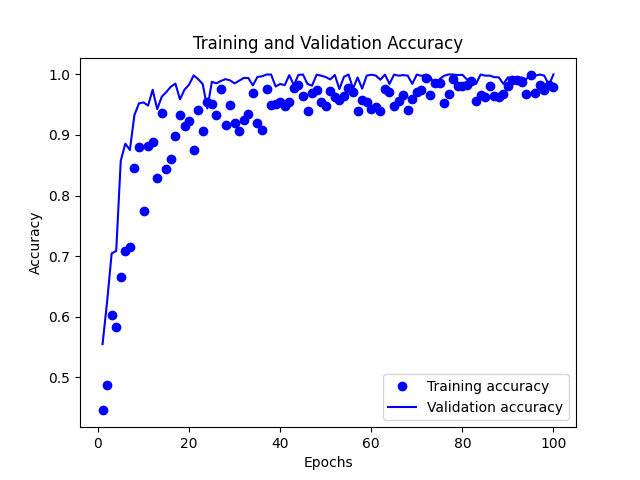

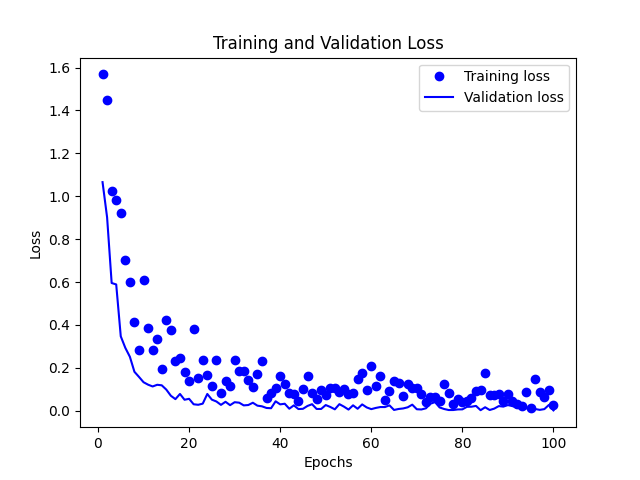

In [27]:
from IPython.display import display, Image

# Show an image
display(Image(filename="./training_history_accuracy.png"))
display(Image(filename="./training_history_loss.png"))